In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../')  # 返回notebook的上一级目录
# sys.path.append('E:\GitHub\QA-abstract-and-reasoning')  # 效果同上

In [3]:
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from seq2seq_tf2.batcher import train_batch_generator
from utils.data_loader import build_dataset,load_dataset,preprocess_sentence,load_test_dataset
from utils.wv_loader import load_embedding_matrix,load_vocab
from utils.config import *
from utils.params_utils import *
from utils.gpu_utils import config_gpu
from utils.plot_utils import plot_attention

from gensim.models.word2vec import LineSentence, Word2Vec
from tqdm import tqdm

import warnings

warnings.filterwarnings("ignore")

D:\Learning\Project\QA\version1


Building prefix dict from the default dictionary ...
2020-05-21 14:01:25,379 : DEBUG : Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\17854\AppData\Local\Temp\jieba.cache
2020-05-21 14:01:25,381 : DEBUG : Loading model from cache C:\Users\17854\AppData\Local\Temp\jieba.cache
Loading model cost 0.611 seconds.
2020-05-21 14:01:25,992 : DEBUG : Loading model cost 0.611 seconds.
Prefix dict has been built successfully.
2020-05-21 14:01:25,993 : DEBUG : Prefix dict has been built successfully.


In [5]:
tf.__version__

'2.1.0'

In [6]:
# 配置GPU
config_gpu()

1 Physical GPUs, 1 Logical GPUs


# 加载数据

In [9]:
# 加载vocab
vocab,reverse_vocab=load_vocab(vocab_path)

# 加载预训练权重
embedding_matrix=load_embedding_matrix()

train_x,train_y,test_x = load_dataset()  # 数据集

# 基本参数设置

In [11]:
# 取部分数据进行训练
sample_num=64
train_X=train_x[:sample_num]
train_Y=train_y[:sample_num]

In [12]:
# 训练集的长度
BUFFER_SIZE = len(train_X)

# 输入的长度
max_length_inp=train_X.shape[1]
# 输出的长度
max_length_targ=train_Y.shape[1]

BATCH_SIZE = 8

# 训练一轮需要迭代多少步
steps_per_epoch = len(train_X)//BATCH_SIZE

# 词向量维度
embedding_dim = 500

# 隐藏层单元数
units = 32

# 词表大小
vocab_size = len(vocab)

# 构建训练集
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

# 构建Encoder

返回值具体是什么可以查看[RNN文档](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/RNN)
Output shape:

- If return_state: a list of tensors. The first tensor is the output. The remaining tensors are the last states, each with shape (batch_size, state_size), where state_size could be a high dimension tensor shape.


- If return_sequences: N-D tensor with shape (batch_size, timesteps, output_size), where output_size could be a high dimension tensor shape, or (timesteps, batch_size, output_size) when time_major is True.


- Else, N-D tensor with shape (batch_size, output_size), where output_size could be a high dimension tensor shape.

[这篇文章](https://blog.csdn.net/u011327333/article/details/78501054)分析了`return_state` 和 `return_sequences`取True 或 False 的四种情况  


[GRU官方文档](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/GRU#class_gru)  

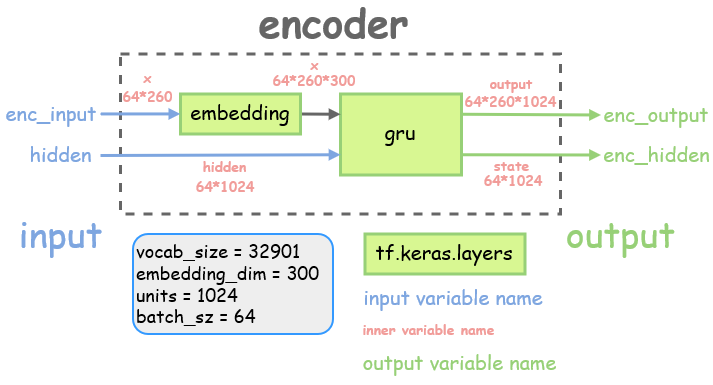


In [14]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim ,embedding_matrix , enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units # whats this
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        # print("after embedding",x.shape)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        # (一批数据大小, 隐层的维数)
        return tf.zeros((self.batch_sz, self.enc_units))

In [15]:
vocab_size, embedding_dim, units, BATCH_SIZE

(31820, 500, 32, 8)

In [16]:
embedding_matrix.shape

(31820, 500)

In [17]:
encoder = Encoder(vocab_size, embedding_dim,embedding_matrix, units, BATCH_SIZE)

In [18]:
x = tf.cast(train_x[:BATCH_SIZE], dtype=tf.int32)
print(x.shape)
x

(8, 200)


<tf.Tensor: shape=(8, 200), dtype=int32, numpy=
array([[31816,   415,   903, ..., 31818, 31818, 31818],
       [31816,   813, 31819, ..., 31818, 31818, 31818],
       [31816,  1393,    88, ...,  3321,  6567,  2232],
       ...,
       [31816,   956,    39, ...,     0,  1648,   340],
       [31816,  1553,   294, ..., 31818, 31818, 31818],
       [31816, 31819,  1063, ..., 31818, 31818, 31818]])>

In [19]:
sample_hidden = encoder.initialize_hidden_state()
sample_hidden.shape

TensorShape([8, 32])

In [20]:
# 感觉这个output的shape很像权重
sample_output, sample_hidden = encoder(x, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (8, 200, 32)
Encoder Hidden state shape: (batch size, units) (8, 32)


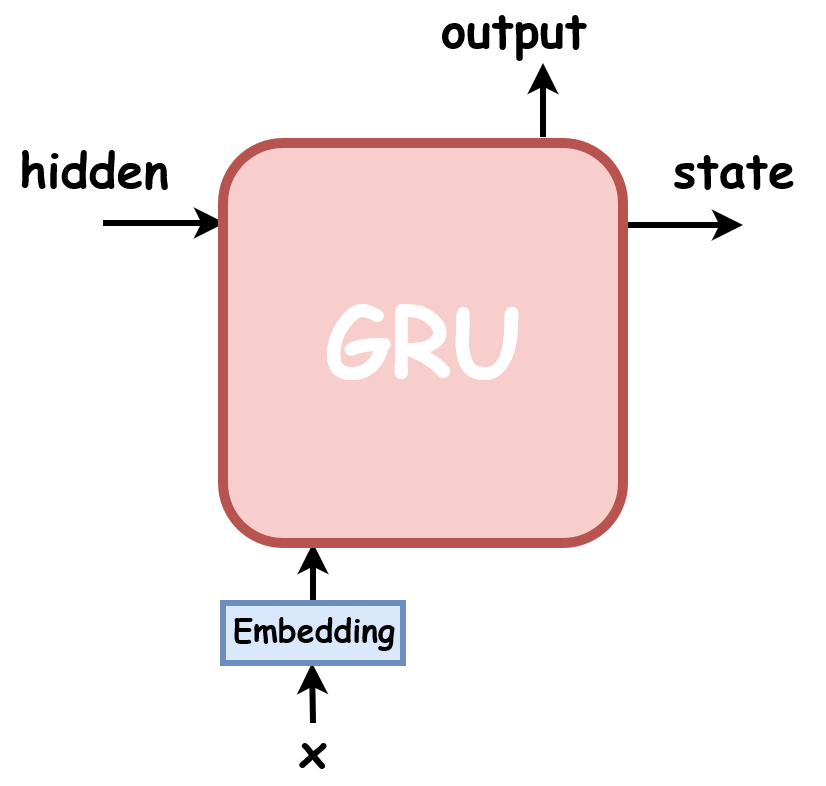

In [21]:
len(encoder.weights)

4

# 构建Attention

In [22]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        
        # query为上次的GRU隐藏层
        # values为编码器的编码结果enc_output
        # 在seq2seq模型中，St是后面的query向量，而编码过程的隐藏状态hi是values。
        hidden_with_time_axis = tf.expand_dims(query, 1)

        
        # 计算注意力权重值
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # # 使用注意力权重*编码器输出作为返回值，将来会作为解码器的输入
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [23]:
attention_layer = BahdanauAttention(10)
context_vector, attention_weights = attention_layer(sample_hidden, sample_output)

print("context_vector shape: (batch size, units) {}".format(context_vector.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

context_vector shape: (batch size, units) (8, 32)
Attention weights shape: (batch_size, sequence_length, 1) (8, 200, 1)


# 构建Decoder

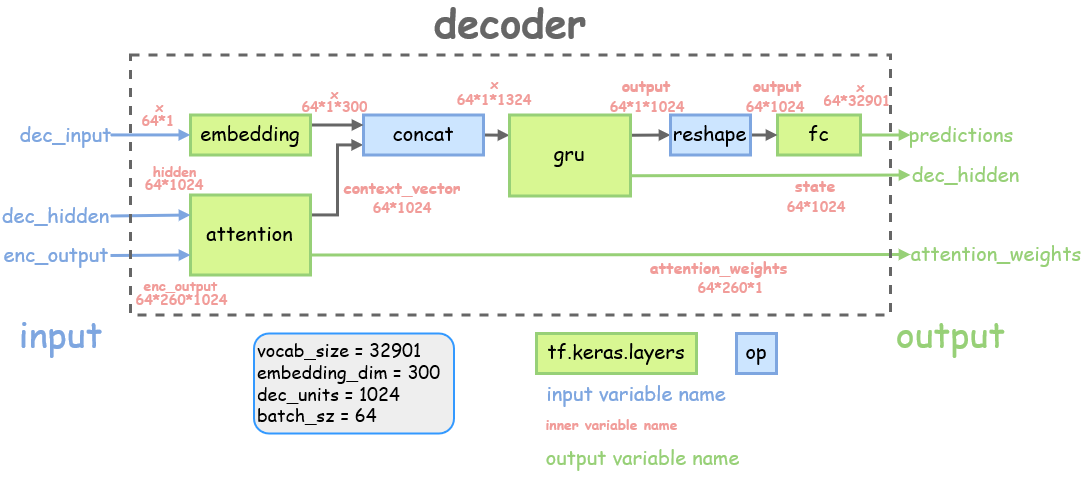

In [24]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim,embedding_matrix, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        # 之前好像没加softmax
        self.fc = tf.keras.layers.Dense(vocab_size, activation="softmax")  # 为了softmax层数要保持一致

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):

        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        x = self.fc(output)
        
        return x, state, attention_weights

In [25]:
decoder = Decoder(vocab_size, embedding_dim,embedding_matrix, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (8, 31820)


# 优化器和损失函数

[SparseCategoricalCrossentropy](https://tensorflow.google.cn/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)

In [26]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

pad_index=vocab['<PAD>']

def loss_function(real, pred):
    # 相当于把<PAD>给过滤了，词如果是<PAD>那它对应位置的mask为 False
    # real = [0, 1, 2] pad_index = 2 --> mask = [True, Ture, False]
    # 用于后面不计算<PAD>词的损失
    mask = tf.math.logical_not(tf.math.equal(real, pad_index))
    # 计算损失
    # real = [0, 1, 2] pred = [[.91,.4,.5],[.0, .88, .1],[.3, .3, .94]]
    loss_ = loss_object(real, pred)
    # bool型转float(与loss_的数据类型一致)
    mask = tf.cast(mask, dtype=loss_.dtype)
    # 不计算<PAD>词损失值
    loss_ *= mask
    # 返回损失值之和
    return tf.reduce_mean(loss_)

# 保存点设置

In [42]:
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [43]:
checkpoint_prefix

'D:\\Learning\\Project\\QA\\version1\\data\\checkpoints\\training_checkpoints_mask_loss_dim500_seq\\ckpt'

# 训练

In [29]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        # 1. 构建encoder
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        # 2. 复制
        dec_hidden = enc_hidden
        # 3. <START> * BATCH_SIZE 
        # shape: (BATCH_SIZE, 1)
        dec_input = tf.expand_dims([vocab['<START>']] * BATCH_SIZE, 1)
    
        # Teacher forcing - feeding the target as the next input
        # 这里跟decoder有点区别，是一个一个输入固定位置的词 dec_input的 shape: (BATCH_SIZE, 1)
        # 例如一批数据64句话，第一轮输入<START>,第二轮输入所有句子的第一个词...
        for t in range(1, targ.shape[1]):
            # targ.shape = (BATCH_SIZE, len_train_Y) 第二个参数是句子长度
            # decoder(x, hidden, enc_output)
            # predictions用于sotfmax的(BATCH_SIZE, VOCAB_SIZE)向量
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            
            # 为什么损失值是累加的: 注意这里是targ[:, t]不是targ[:t]
            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            # 为下一个输入做准备
            dec_input = tf.expand_dims(targ[:, t], 1)  # shape: (BATCH_SIZE, 1)

        batch_loss = (loss / int(targ.shape[1]))

        variables = encoder.trainable_variables + decoder.trainable_variables

        gradients = tape.gradient(loss, variables)

        optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss

In [30]:
EPOCHS = 1
TRAIN = True
if TRAIN:
    for epoch in range(EPOCHS):
        start = time.time()

        # 初始化隐藏层
        enc_hidden = encoder.initialize_hidden_state()
        total_loss = 0

        for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
            # 
            batch_loss = train_step(inp, targ, enc_hidden)
            total_loss += batch_loss

            if batch % 1 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                             batch,
                                                             batch_loss.numpy()))
        # saving (checkpoint) the model every 2 epochs
        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                          total_loss / steps_per_epoch))
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 5.0259
Epoch 1 Batch 1 Loss 3.6667
Epoch 1 Batch 2 Loss 5.7529
Epoch 1 Batch 3 Loss 2.8132
Epoch 1 Batch 4 Loss 5.3420
Epoch 1 Batch 5 Loss 5.1207
Epoch 1 Batch 6 Loss 4.7414
Epoch 1 Batch 7 Loss 5.3104
Epoch 1 Loss 4.7216
Time taken for 1 epoch 31.22548747062683 sec



# 回答

* The evaluate function is similar to the training loop, except we don't use <u>*teacher forcing*</u> here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

王世洋：
观看“初心如磐 使命在肩”专题党课心得：
看到那么多的医护人员，为了病人无私奉献，我深深的受到了触动，正是由于他们的无私奉献，才会有千家万户的阖家欢乐。
这里边有很多的人是党员，也有很多人志愿成为一名中国共产党的一员，我相信这正是中国共产党一心一意的为人民服务的宗旨对他们的影响，我相信，坚持高举党的旗帜，积极为人民服务，发挥自己的能量，才能更好的实现自己的价值。

In [45]:
# from utils.data_loader import preprocess_sentence
import matplotlib as mpl
mpl.rcParams['font.family'] = 'STSong'  # 显示中文
import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

In [47]:
max_length_targ = 41
max_length_inp = 200
units = 512

In [51]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    # 需要整合下自己的预处理
    # 这里max_length_inp-2为何要-2
    # 原本计算得到最大长度为258，经过pad后长度变为260了，如果这里继续用260，input长度会变成262
    inputs = preprocess_sentence.sentence_proc_eval(sentence,max_length_inp-2,vocab)

    inputs = tf.convert_to_tensor(inputs)

    result = ''
    
    hidden = [tf.zeros((1, units))]  # 这个是不是可以调之前的encoder里的初始化方法
    
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    
    dec_input = tf.expand_dims([vocab['<START>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        # ic(predictions.numpy().sum(axis=1))
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        
        attention_plot[t] = attention_weights.numpy()
        # predictions shape: (1, vocab_size) 和numpy 的argmax()还是有点区别的
        predicted_id = tf.argmax(predictions[0]).numpy()

        result += vocab_reversed[predicted_id] + ' '
        if vocab_reversed[predicted_id] == '<STOP>':
            # 去掉结尾的空格
            return result.strip(), sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [56]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    sentence = ppreprocess_sentence(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [57]:
sentence='北京 汽车 BJ 20 自动挡 最低 配 <UNK> 速 续航 技师说'

translate(sentence)

NameError: name 'pp' is not defined